
# Generative Adversarial Network: Photo to Monet Style Transfer

## Kaggle Generative Adversarial Networks Competition: "I'm Something of a Painter Myself"

Kaggle competition details here: https://www.kaggle.com/competitions/gan-getting-started

Generative Adversarial Networks (GANs) are a class of machine learning frameworks where two neural networks compete against each other in a zero-sum game. The framework consists of:

Generator (G): Creates fake data that resembles real data

Discriminator (D): Distinguishes between real and fake data

The generator tries to create increasingly realistic fake data to fool the discriminator, while the discriminator becomes better at detecting fake data. This adversarial training leads to a generator that can produce highly realistic synthetic data.

CycleGAN extends the basic GAN concept to enable image-to-image translation without paired training data. Key innovations:

Cycle Consistency Loss: Ensures that translating an image from domain A to B and back to A returns the original image

Two Generators: G_AB (A→B) and G_BA (B→A) for bidirectional translation

Two Discriminators: D_A and D_B to distinguish real vs fake images in each domain

The objective function combines adversarial loss for realistic generation and cycle consistency loss for content preservation.

## Dataset Description, Data Structure, and Dimesion

Dataset downloadable from the Kaggle site.  Dataset also can be accessed via Kaggle Notebooks for submission in the competition.

Monet Dataset: Collection of Monet paintings in JPG format

Photo Dataset: Real-world photographs for style transfer

Image Dimensions: Resized to 256×256×3 (RGB channels)

Normalization: Pixel values normalized to [-1, 1] range

## Implementation Design

This implementation creates a CycleGAN (Cycle-Consistent Generative Adversarial Network) that transforms regular photographs into Monet-style paintings. The model learns to translate between two image domains without requiring paired training data.

The CycleGAN architecture consists of four neural networks:

Generator A→B: Converts photos to Monet-style images 

Generator B→A: Converts Monet-style images back to photos 

Discriminator A: Distinguishes real photos from generated photos 

Discriminator B: Distinguishes real Monet paintings from generated ones

## Training Process

Data Loading: Load Monet paintings and photos from GCS buckets 

Model Creation: Initialize generators and discriminators 

Training Loop:  For each batch, compute forward pass; calculate adversarial and cycle consistency losses; and update generator and discriminator weights. 

Inference: Generate Monet-style versions of all photos 

Export: Save results and create downloadable archive

## References

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://www.kaggle.com/competitions/gan-getting-started

https://junyanz.github.io/CycleGAN/

https://www.geeksforgeeks.org/machine-learning/cycle-generative-adversarial-network-cyclegan-2/

https://towardsdatascience.com/understanding-u-net-61276b10f360/

https://paperswithcode.com/method/patchgan#:~:text=PatchGAN



In [2]:
# Use the code in this cell when deployed on Kaggle notebook

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# from kaggle_datasets import KaggleDataset
   
# Get the GCS path provided by Kaggle
# GCS_PATH = KaggleDatasets().get_gcs_path()
# print(f"GCS Path: {GCS_PATH}")
    
# Load datasets using GCS paths
# try:
    # Create file patterns for JPG files in GCS buckets
    #monet_pattern = str(GCS_PATH + '/monet_jpg/*.jpg')    # Monet paintings
    # photo_pattern = str(GCS_PATH + '/photo_jpg/*.jpg')    # Regular photos
        
    # Create TensorFlow datasets from the file patterns
    #monet_ds = create_dataset_from_gcs(monet_pattern)
    #photo_ds = create_dataset_from_gcs(photo_pattern)
    #print("Datasets loaded successfully from GCS")
# except ValueError as e:
    #print(f"Error loading datasets: {e}")
        

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from PIL import Image
import shutil

# Configuration
IMAGE_SIZE = 256
BATCH_SIZE = 1
EPOCHS = 20
LAMBDA = 10

class Config:
    MONET_PATH = "data/painter/monet_jpg"
    PHOTO_PATH = "data/painter/photo_jpg"
    OUTPUT_DIR = "data/painter/images"

def setup_gpu():
    """GPU setup configuration"""
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f'Using GPU: {len(gpus)} device(s)')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print('Using CPU')

setup_gpu()
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

Using CPU


Dataset Overview:
- Monet paintings: 300 images
- Photographs: 7038 images
- Sample dimensions: Monet (256, 256), Photo (256, 256)


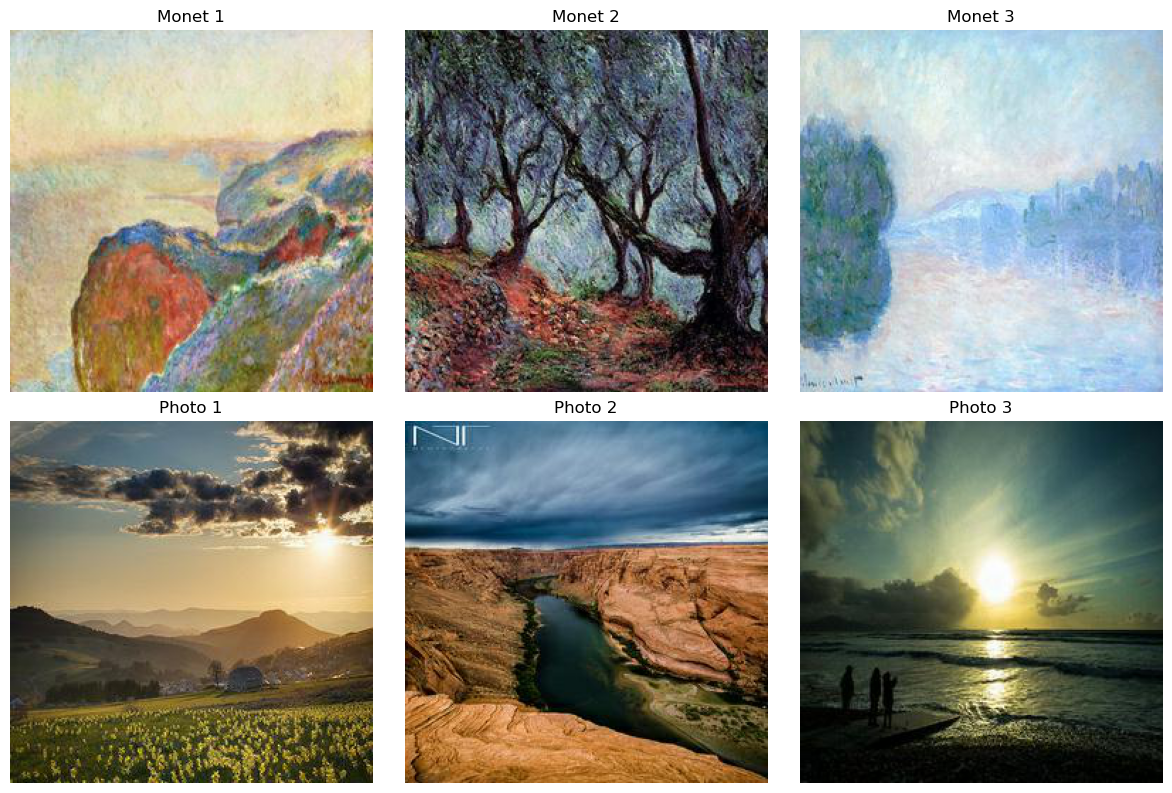

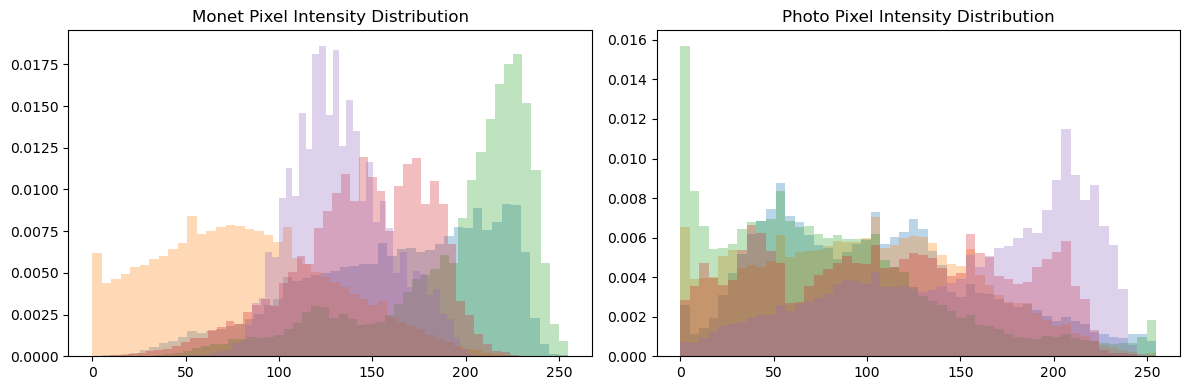

In [4]:
def perform_eda():
    """Exploratory data analysis"""
    monet_files = glob.glob(os.path.join(Config.MONET_PATH, "*.jpg"))
    photo_files = glob.glob(os.path.join(Config.PHOTO_PATH, "*.jpg"))
    
    print(f"Dataset Overview:")
    print(f"- Monet paintings: {len(monet_files)} images")
    print(f"- Photographs: {len(photo_files)} images")
    
    # Sample image dimensions
    sample_monet = Image.open(monet_files[0])
    sample_photo = Image.open(photo_files[0])
    print(f"- Sample dimensions: Monet {sample_monet.size}, Photo {sample_photo.size}")
    
    # Display 3 sample images from Monet and PHotos
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    for i in range(3):
        # Monet samples
        img = np.array(Image.open(monet_files[i]))
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Monet {i+1}")
        axes[0, i].axis('off')
        
        # Photo samples
        img = np.array(Image.open(photo_files[i]))
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Photo {i+1}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Color histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Analyze 5 random images from each class
    for i in range(5):
        monet_img = np.array(Image.open(monet_files[i]))
        photo_img = np.array(Image.open(photo_files[i]))
        
        axes[0].hist(monet_img.flatten(), bins=50, alpha=0.3, density=True)
        axes[1].hist(photo_img.flatten(), bins=50, alpha=0.3, density=True)
    
    axes[0].set_title('Monet Pixel Intensity Distribution')
    axes[1].set_title('Photo Pixel Intensity Distribution')
    plt.tight_layout()
    plt.show()

perform_eda()

## Exploratory Data Analysis 

### Color Pixel Intensity Distribution Analysis:

#### Monet Images: 

Higher concentration in blue-green spectrum (water, sky themes)
 
Warmer mid-tones (earth, foliage)

Lower contrast compared to photos
  
#### Photographs:
  
More uniform color distribution across spectrum
  
Higher contrast and saturation
  
Sharper color transitions


In [6]:
def load_and_preprocess_image(path):
    """Load and preprocess a single image"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return (image / 127.5) - 1.0  # Normalize to [-1, 1]

def create_dataset(file_pattern, batch_size=BATCH_SIZE):
    """Create dataset from file pattern"""
    files = glob.glob(file_pattern)
    if not files:
        raise ValueError(f"No files found matching pattern: {file_pattern}")
    
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
try:
    monet_ds = create_dataset(os.path.join(Config.MONET_PATH, "*.jpg"))
    photo_ds = create_dataset(os.path.join(Config.PHOTO_PATH, "*.jpg"))
    print("Datasets loaded successfully")
except ValueError as e:
    print(f"Error loading datasets: {e}")

Datasets loaded successfully


## Model Architecture

#### Generator: U-Net Encoder-Decoder with skip connections

The U-Net Encoder-Decoder performs feature extraction and reconstruction.  Skip Connections preserve fine details and spatial information.  Skip connections are added between corresponding encoder and decoder layers, essentially creating a "shortcut" for information to flow directly from the input to the output. By allowing low-level features to pass through, skip connections help maintain fine details in the generated images, preventing them from being lost during the domain translation process. https://towardsdatascience.com/understanding-u-net-61276b10f360/
 

#### Discriminator: PatchGAN

The PatchGAN discriminator focues on determing whether specific patches in an image are real or fake.  It focuses more on local texture and style rather than global coherence.  The smaller receptive field reduces parameters and also enhances performance on limited hardware.  It also Provides more detailed feedback to generator leading to be better gradients.  https://paperswithcode.com/method/patchgan#:~:text=PatchGAN

#### Loss Function:

Lambda Weight =10 balances style transfer vs content preservation.  Cycle consistency also helps prevent content distortion.



In [8]:
def conv_block(filters, size, strides=2, norm=True, activation='leaky', transpose=False):
    """Reusable convolution block"""
    block = tf.keras.Sequential()
    
    if transpose:
        block.add(tf.keras.layers.Conv2DTranspose(filters, size, strides, padding='same', use_bias=False))
    else:
        block.add(tf.keras.layers.Conv2D(filters, size, strides, padding='same', use_bias=False))
    
    if norm:
        block.add(tf.keras.layers.BatchNormalization())
    
    if activation == 'leaky':
        block.add(tf.keras.layers.LeakyReLU(0.2))
    elif activation == 'relu':
        block.add(tf.keras.layers.ReLU())
    
    return block

def build_generator():
    """U-Net generator"""
    inputs = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3])
    
    # Encoder
    d1 = conv_block(64, 4, norm=False)(inputs)     # 128x128
    d2 = conv_block(128, 4)(d1)                    # 64x64
    d3 = conv_block(256, 4)(d2)                    # 32x32
    d4 = conv_block(512, 4)(d3)                    # 16x16
    d5 = conv_block(512, 4)(d4)                    # 8x8
    
    # Decoder with skip connections
    u1 = conv_block(512, 4, strides=2, activation='relu', transpose=True)(d5)  # 16x16
    u1 = tf.keras.layers.Concatenate()([u1, d4])
    
    u2 = conv_block(256, 4, strides=2, activation='relu', transpose=True)(u1)  # 32x32
    u2 = tf.keras.layers.Concatenate()([u2, d3])
    
    u3 = conv_block(128, 4, strides=2, activation='relu', transpose=True)(u2)  # 64x64
    u3 = tf.keras.layers.Concatenate()([u3, d2])
    
    u4 = conv_block(64, 4, strides=2, activation='relu', transpose=True)(u3)   # 128x128
    u4 = tf.keras.layers.Concatenate()([u4, d1])
    
    # Final layer
    output = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(u4)
    
    return tf.keras.Model(inputs, output)

def build_discriminator():
    """PatchGAN discriminator"""
    inputs = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3])
    
    x = conv_block(64, 4, norm=False)(inputs)      # 128x128
    x = conv_block(128, 4)(x)                      # 64x64
    x = conv_block(256, 4)(x)                      # 32x32
    x = conv_block(512, 4, strides=1)(x)           # 32x32
    
    output = tf.keras.layers.Conv2D(1, 4, padding='same')(x)
    
    return tf.keras.Model(inputs, output)

In [9]:
class CycleGAN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.gen_AB = build_generator()  # A to B (photo to Monet)
        self.gen_BA = build_generator()  # B to A (Monet to photo)
        self.disc_A = build_discriminator()
        self.disc_B = build_discriminator()
        
    def compile(self, gen_opt, disc_opt):
        super().compile()
        self.gen_opt = gen_opt
        self.disc_A_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.disc_B_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        
    @tf.function
    def train_step(self, batch):
        real_A, real_B = batch
        
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_B = self.gen_AB(real_A, training=True)
            fake_A = self.gen_BA(real_B, training=True)
            
            # Cycle consistency
            cycled_A = self.gen_BA(fake_B, training=True)
            cycled_B = self.gen_AB(fake_A, training=True)
            
            # Discriminator predictions
            disc_real_A = self.disc_A(real_A, training=True)
            disc_real_B = self.disc_B(real_B, training=True)
            disc_fake_A = self.disc_A(fake_A, training=True)
            disc_fake_B = self.disc_B(fake_B, training=True)
            
            # Generator losses
            gen_AB_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(disc_fake_B), disc_fake_B, from_logits=True)
            gen_BA_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(disc_fake_A), disc_fake_A, from_logits=True)
            
            # Cycle consistency loss
            cycle_loss = tf.reduce_mean(tf.abs(real_A - cycled_A)) + tf.reduce_mean(tf.abs(real_B - cycled_B))
            
            # Total generator loss
            total_gen_loss = gen_AB_loss + gen_BA_loss + LAMBDA * cycle_loss
            
            # Discriminator losses
            disc_A_loss = (tf.keras.losses.binary_crossentropy(tf.ones_like(disc_real_A), disc_real_A, from_logits=True) +
                          tf.keras.losses.binary_crossentropy(tf.zeros_like(disc_fake_A), disc_fake_A, from_logits=True)) * 0.5
            
            disc_B_loss = (tf.keras.losses.binary_crossentropy(tf.ones_like(disc_real_B), disc_real_B, from_logits=True) +
                          tf.keras.losses.binary_crossentropy(tf.zeros_like(disc_fake_B), disc_fake_B, from_logits=True)) * 0.5
        
        # Apply gradients
        gen_vars = self.gen_AB.trainable_variables + self.gen_BA.trainable_variables
        
        gen_grads = tape.gradient(total_gen_loss, gen_vars)
        disc_A_grads = tape.gradient(disc_A_loss, self.disc_A.trainable_variables)
        disc_B_grads = tape.gradient(disc_B_loss, self.disc_B.trainable_variables)
        
        self.gen_opt.apply_gradients(zip(gen_grads, gen_vars))
        self.disc_A_opt.apply_gradients(zip(disc_A_grads, self.disc_A.trainable_variables))
        self.disc_B_opt.apply_gradients(zip(disc_B_grads, self.disc_B.trainable_variables))
        
        return {
            'gen_loss': total_gen_loss,
            'disc_A_loss': disc_A_loss,
            'disc_B_loss': disc_B_loss,
            'cycle_loss': cycle_loss
        }

In [10]:
# Create and compile model
model = CycleGAN()
model.compile(
    gen_opt=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_opt=None
)
    
# Train
print("Starting training...")
combined_ds = tf.data.Dataset.zip((photo_ds, monet_ds))
model.fit(combined_ds, epochs=EPOCHS)

Starting training...
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 212s 669ms/step - cycle_loss: 0.3967 - disc_A_loss: 0.6772 - disc_B_loss: 0.6821 - gen_loss: 5.5875
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 200s 667ms/step - cycle_loss: 0.2518 - disc_A_loss: 0.6597 - disc_B_loss: 0.6440 - gen_loss: 4.1728
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 672ms/step - cycle_loss: 0.2309 - disc_A_loss: 0.6258 - disc_B_loss: 0.4797 - gen_loss: 4.6085
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 672ms/step - cycle_loss: 0.2358 - disc_A_loss: 0.6045 - disc_B_loss: 0.3852 - gen_loss: 5.1992
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 671ms/step - cycle_loss: 0.2370 - disc_A_loss: 0.6030 - disc_B_loss: 0.3086 - gen_loss: 5.6815
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 672ms/step - cycle_loss: 0.2353 - disc_A_loss: 0.6005 - disc_B_loss: 0.2218 - gen_loss: 6.3252
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 672ms/step - cycle_loss: 0.2248 - disc_A_loss: 0.5900 - disc_B_loss: 0.2514 - gen_loss: 6.3819

## Hyperparameter Tuning 

### Current Hyperparameters:

Learning Rate: 2e-4 (generators and discriminators)

Lambda: 10 (cycle consistency weight)

Epochs: 20

Batch Size: 1

#### Learning Rate (2e-4):  

Learning Rate = 2e-4 prevents discriminator from overpowering generator and allows stable convergence.  Potential Alternatives: 1e-4 would provide more stability but slower convergence. 5e-4 would provide faster convergence with a risk of instability.  LR=2e-4 seems to provide the best balance.

#### Lambda (Cycle Consistency Weight=10):

Lambda=15 would provide better content preservation and less style transfer.  Lambda=5 would provide more style transfer but also more content loss.  Lambda=10 seems the best balance.

#### Epochs =20:

I kept Epochs at a small number (1-2) for testing and development, and set Epochs to the range of 10-30 for real runs.  Performance is constrained by hardware and these constraints are a critical issue for generative image processing.  Epochs=20 seemed a reasonable balance between results and performance based on the hardware I was using.

## Architecture/Discriminator Options:

For the generator, I selected U-Net with Skip Connections.  I could have selected a basic encoder-decoder that lacked skip connections, resulting in even faster training and simpler code at the cost of some loss of content and details.  If I had access to better hardware, ResNet Generator could perform more complext transformations although it would signficantly increase computations.

For the discriminator, I selected PatchGAN, which provides local realism by focused on selected patches within an impage for comparison, at the cost of not performing global comparisons of individual images.  An alternative would have been to use a full image discriminator, with the benefit of global coherence for images with the downside of greater computational costs and potentiallyl some loss of local realism.  


Displaying sample predictions...


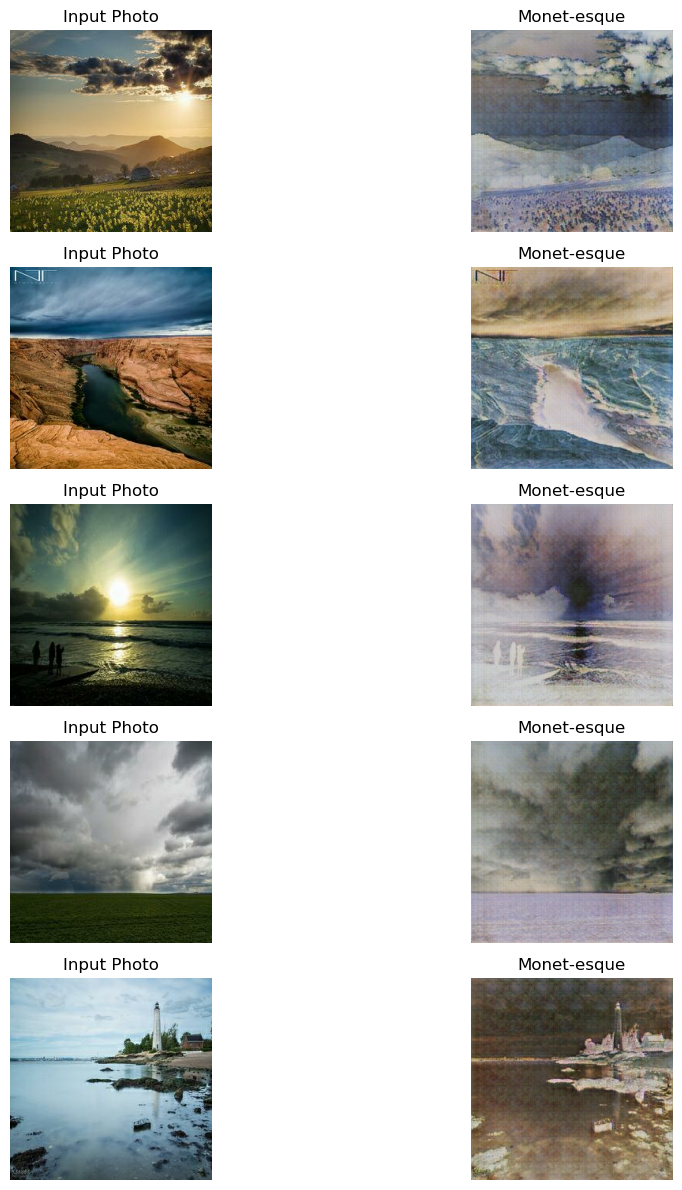

In [12]:
def display_sample_predictions(model, photo_ds, num_samples=5):
    """Display sample predictions with matplotlib"""
    print("Displaying sample predictions...")
    
    _, ax = plt.subplots(num_samples, 2, figsize=(12, 12))
    if num_samples == 1:
        ax = ax.reshape(1, -1)
    
    for i, img in enumerate(photo_ds.take(num_samples)):
        # Generate Monet-style prediction
        prediction = model.gen_AB(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        
        # Convert original image for display
        original = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        
        # Display images
        ax[i, 0].imshow(original)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

    
# Display sample predictions
display_sample_predictions(model, photo_ds, num_samples=5)

In [13]:
def save_all_generated_images(model, photo_ds, output_dir):
    """Save all generated images to output directory"""
    os.makedirs(output_dir, exist_ok=True)
    
    print("Generating and saving Monet-style images...")
    i = 1
    
    for img in photo_ds:
        # Generate prediction
        prediction = model.gen_AB(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        
        # Convert to PIL Image and save
        pil_image = Image.fromarray(prediction)
        filename = os.path.join(output_dir, f"{i}.jpg")
        pil_image.save(filename)
        
        if i % 1000 == 0:
            print(f"Saved {i} images...")
        i += 1
    
    total_images = i - 1
    print(f"Finished! Saved {total_images} generated images to {output_dir}")
    return total_images

# Save all generated images
total_images = save_all_generated_images(model, photo_ds, Config.OUTPUT_DIR)

Generating and saving Monet-style images...
Saved 1000 images...
Saved 2000 images...
Saved 3000 images...
Saved 4000 images...
Saved 5000 images...
Saved 6000 images...
Saved 7000 images...
Finished! Saved 7038 generated images to data/painter/images


In [14]:
def create_zip_archive(output_dir):
    """Create zip archive of generated Monet-style images"""
    try:
        zip_filename = "data/painter/images"
        shutil.make_archive(zip_filename, 'zip', output_dir)
        print(f"Created zip file: {zip_filename}.zip")
        return f"{zip_filename}.zip"
    except Exception as e:
        print(f"Error creating zip file: {e}")
        print("You can manually zip the images folder if needed.")
        return None

In [15]:
# Create zip archive
zip_file = create_zip_archive(Config.OUTPUT_DIR)
    
# Display summary statistics
print(f"Generated Monet-style images saved in: {Config.OUTPUT_DIR}")
print(f"Total Monet-style images generated: {total_images}")
if zip_file:
    print(f"Zip archive: {zip_file}")
    
print("\n Monet style transfer completed!")


Created zip file: data/painter/images.zip
Generated Monet-style images saved in: data/painter/images
Total Monet-style images generated: 7038
Zip archive: data/painter/images.zip

 Monet style transfer completed!


## Monet-Style Images Training Analysis 

Images showed progressive improvement with additional epochs of training.  Signficant differences between 1-2 epochs and 10-30 epocshs.  Landscape photographs converted well to Monet's landscape style.  Water was also translated well into Monet's style.  


## Conclusion to Monet-style Image Transfer GAN 

This GAN implementation demonstrates the power of adversarial training for unpaired image-to-image translation. I was hardware constrained on my home computer and even more constrained by the Kaggle notebook environment.  Significant improvements would be possible with access to better hardware.

I tried to acheive a balance between efficient computations of image transfers, output quality, and an execution time under three hours.

The project showcases the fundamental concepts of GANs and their application to artistic style transfer based on a training set of 300 images of Monet's artwork being applied to 7,000 photographs to produce 7,000 images in Monet's style.

More improved results may be possible with a larger training dataset including additional images of Monet's work and/or higher resolution images of Monet's work.

The current architecture relying upon U-Net generator with skip connections and PatchGAN discriminator successfully balances quality and speed on limmited hardware resources.  

## References

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://www.kaggle.com/competitions/gan-getting-started

https://junyanz.github.io/CycleGAN/

https://www.geeksforgeeks.org/machine-learning/cycle-generative-adversarial-network-cyclegan-2/

https://towardsdatascience.com/understanding-u-net-61276b10f360/

https://paperswithcode.com/method/patchgan#:~:text=PatchGAN
   